# Using the ml4qc package for a specific example analysis ("CATI1")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI1".

This is a basic proof-of-concept project designed to explore the potential for ML-based tools to identify outliers and submissions that are likely to be rejected by a human reviewer. The project collected some but not all possible metadata, and every submission was reviewed.

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **duration** - Total number of seconds spent editing form
* **instance_time** - Timestamp in an unusual format; will be dropped
* **TA** - Relative path to text audit `.csv` file
* **pct_conversation** - Percent of form-editing time when conversation was detected ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati1/cati1.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate      6032
starttime           6032
endtime             6031
duration            6032
instance_time       6032
TA                  6032
pct_conversation    6031
review_status       6032
review_quality      6032
dtype: int64

Submission DataFrame review status and quality:
APPROVED    5800
REJECTED     232
Name: review_status, dtype: Int64
OKAY    2992
GOOD    2761
POOR     279
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         1244960
duration_s    1244960
visited_s     1244960
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                              6032
starttime                                                                                   6032
endtime                                                                                     6031
duration                                                                                    6032

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using one of three target definitions:

1. Rejected submissions
2. Submissions classified as poor quality
3. Submissions that are not APPROVED as GOOD quality (i.e., rejected or another quality)

Here, we use PCA to reduce our feature dimensions, targeting 95% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [3]:
%%time

from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.95

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["instance_time", "SubmissionDate", "starttime", "endtime", "duration", "TA"], axis=1).copy(deep=True)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
target_description = "REJECTED"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
# target_description = "Not APPROVED+GOOD"
# classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=None, verbose=True, reweight_classes=True)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Target description: REJECTED
0    5798
1     232
Name: target, dtype: int64

numeric features: 6277
numeric_binary features: 2419
numeric_unit_interval features: 3448
numeric_other features: 410
datetime features: 0
other features: 2
  Starting training set shape: (4522, 6279)
Starting prediction set shape: (1508, 6279)
     Final training set shape: (4522, 699)
   Final prediction set shape: (1508, 699)
CPU times: user 3min 23s, sys: 7.08 s, total: 3min 30s
Wall time: 43 s


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [10]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser("~/ml4qc-data/collab1/cati1/outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 87 (1.4427860696517412%)
CPU times: user 6.48 s, sys: 2.43 s, total: 8.91 s
Wall time: 8.96 s


target,0,1
is_outlier,,
0,0.985512,0.987069
1,0.014488,0.012931


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Logistic regression
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.29482084542518394
Parameters: {'C': 0.0007260521710538799, 'class_weight': 'balanced', 'penalty': 'l2'}

Running prediction model...

  Training set: (4522, 699) (178 positive)
Prediction set: (1508, 699)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  91.31%
         Train precision:  30.49%
     Train avg precision:  63.58%
               Train F-1:  0.46
     Prediction accuracy:  86.94%
    Prediction precision:  13.71%
Prediction avg precision:  21.40%
          Prediction F-1:  0.22
      Test ROC_AUC Score:  0.69

Cross validation results: 

fit_time: 0.06887701352437338 (SD: 0.0042549685468153365)
score_time: 0.002404308319091797 (SD: 0.00017478628046810132)
test_accuracy: 0.8894299939699146 (SD: 0.0117

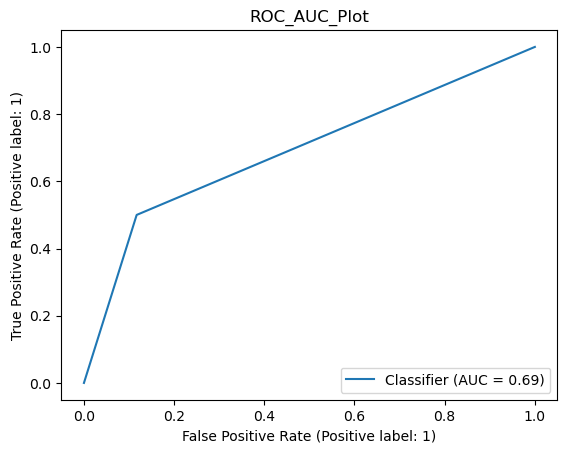

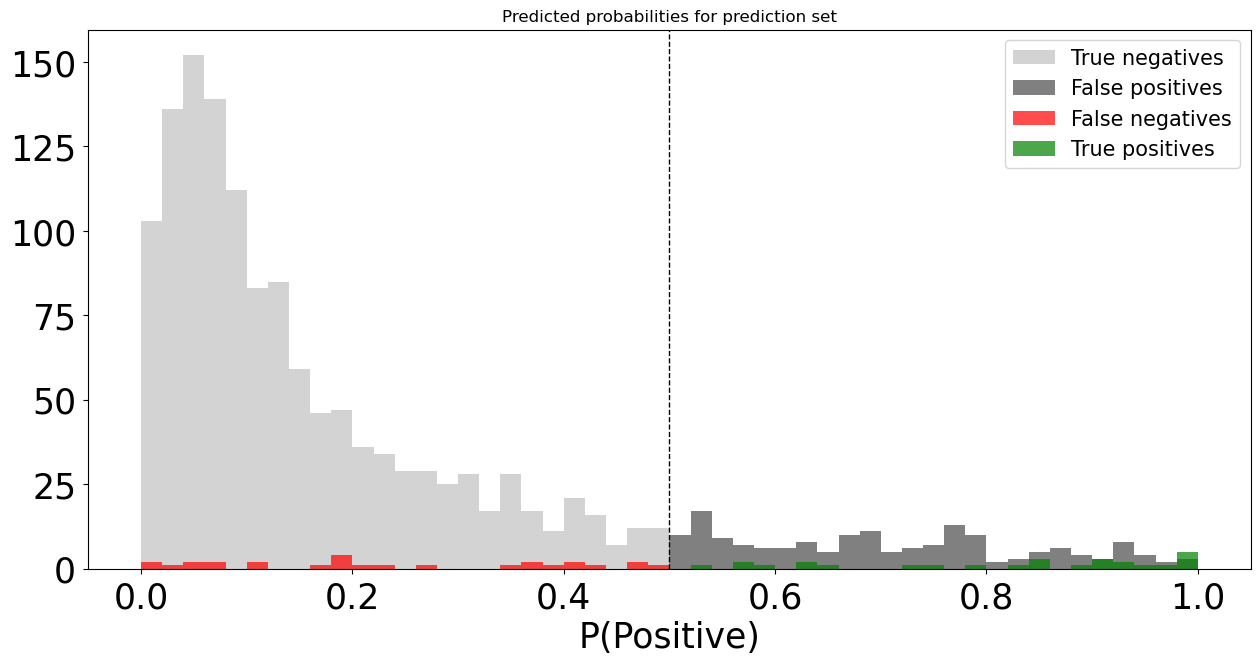

Test P(1) =  3.58%
Test P(1 | predicted 1) =  13.71%
Test P(1 | predicted 0) =  2.06%

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1454
           1       0.14      0.50      0.22        54

    accuracy                           0.87      1508
   macro avg       0.56      0.69      0.57      1508
weighted avg       0.95      0.87      0.90      1508



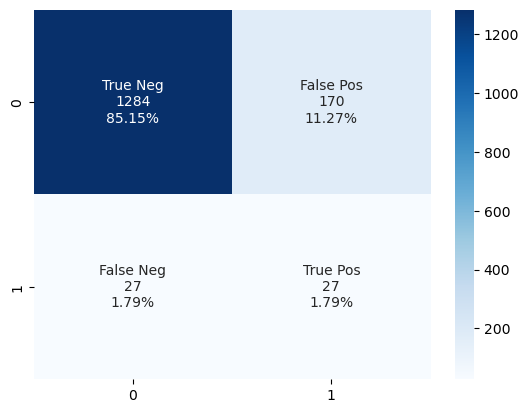

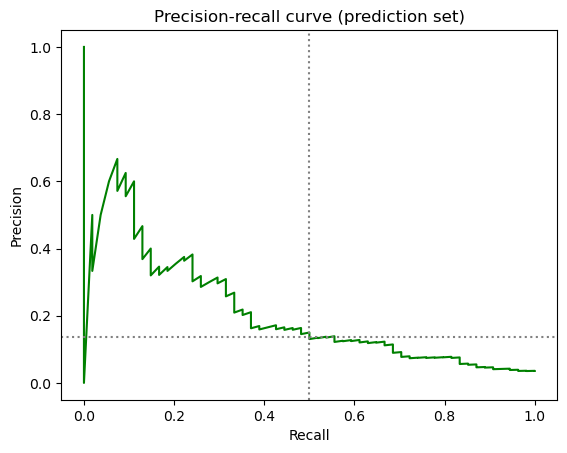

Predictions made: 1508
CPU times: user 8.53 s, sys: 1 s, total: 9.53 s
Wall time: 2min 55s


In [11]:
%%time

model_description = "Logistic regression"
model_scoring = 'f1'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import sklearn as skl
from sklearn.linear_model import LogisticRegression

# first use cross validation to find the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=None, max_iter=1000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': ['balanced', None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=None, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_lr.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Decision tree
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.17379352187336553
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3, 'class_weight': 'balanced'}

Running prediction model...

  Training set: (4522, 699) (178 positive)
Prediction set: (1508, 699)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  78.86%
         Train precision:  13.09%
     Train avg precision:  13.50%
               Train F-1:  0.22
     Prediction accuracy:  77.72%
    Prediction precision:  7.01%
Prediction avg precision:  5.89%
          Prediction F-1:  0.12
      Test ROC_AUC Score:  0.61

Cross validation results: 

fit_time: 0.5905967871348063 (SD: 0.006843706169337586)
score_time: 0.002718400955200195 (SD: 0.0003871852462356353)
test_accuracy: 0

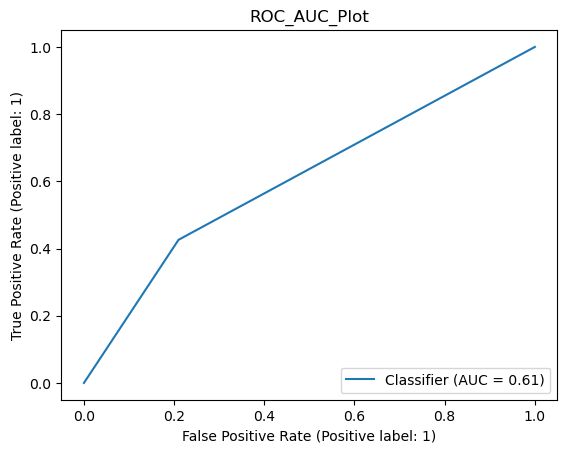

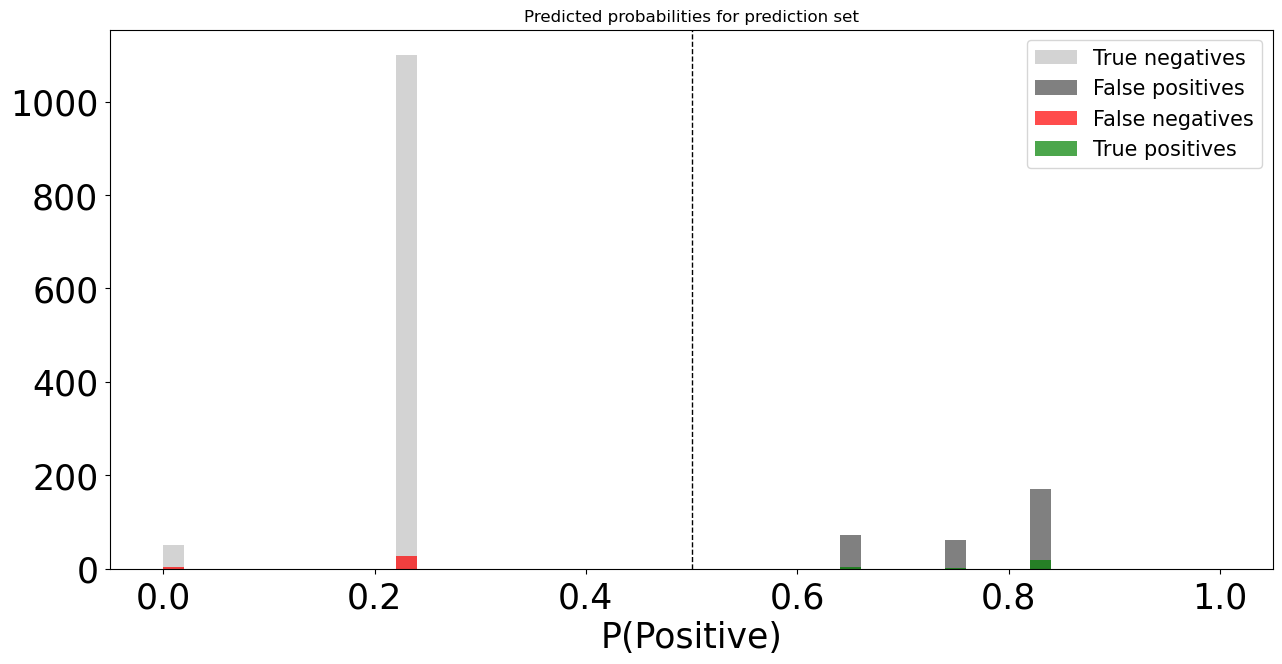

Test P(1) =  3.58%
Test P(1 | predicted 1) =  7.01%
Test P(1 | predicted 0) =  2.63%

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1454
           1       0.07      0.43      0.12        54

    accuracy                           0.78      1508
   macro avg       0.52      0.61      0.50      1508
weighted avg       0.94      0.78      0.85      1508



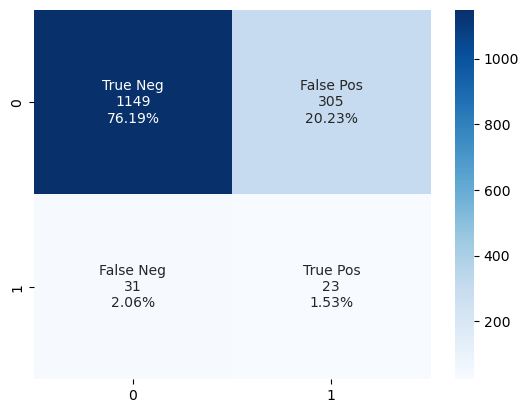

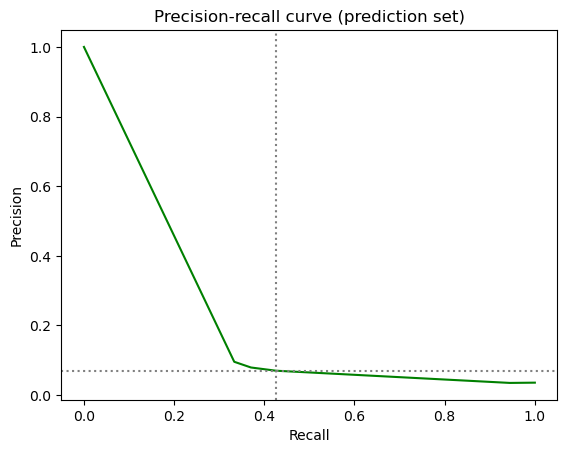

Predictions made: 1508
CPU times: user 11.4 s, sys: 330 ms, total: 11.7 s
Wall time: 1min 14s


In [12]:
%%time

model_description = "Decision tree"
model_scoring = 'f1'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=None)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None, 'balanced']}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=None, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_dt.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Random forest
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.2650170203155709
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'class_weight': 'balanced', 'bootstrap': True}

Running prediction model...

  Training set: (4522, 699) (178 positive)
Prediction set: (1508, 699)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  96.84%
         Train precision:  57.26%
     Train avg precision:  78.29%
               Train F-1:  0.66
     Prediction accuracy:  94.16%
    Prediction precision:  23.44%
Prediction avg precision:  23.55%
          Prediction F-1:  0.25
      Test ROC_AUC Score:  0.62

Cross validation results: 

fit_time: 7.04940447807312 (SD: 0.08043136845390919)
score_time: 0.05388325055440267 (SD: 0.001381190551573347

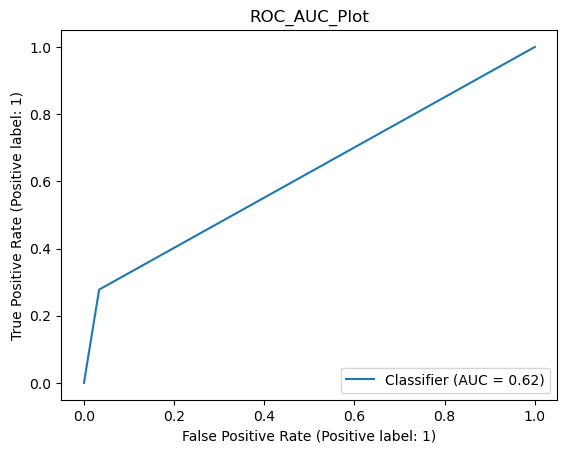

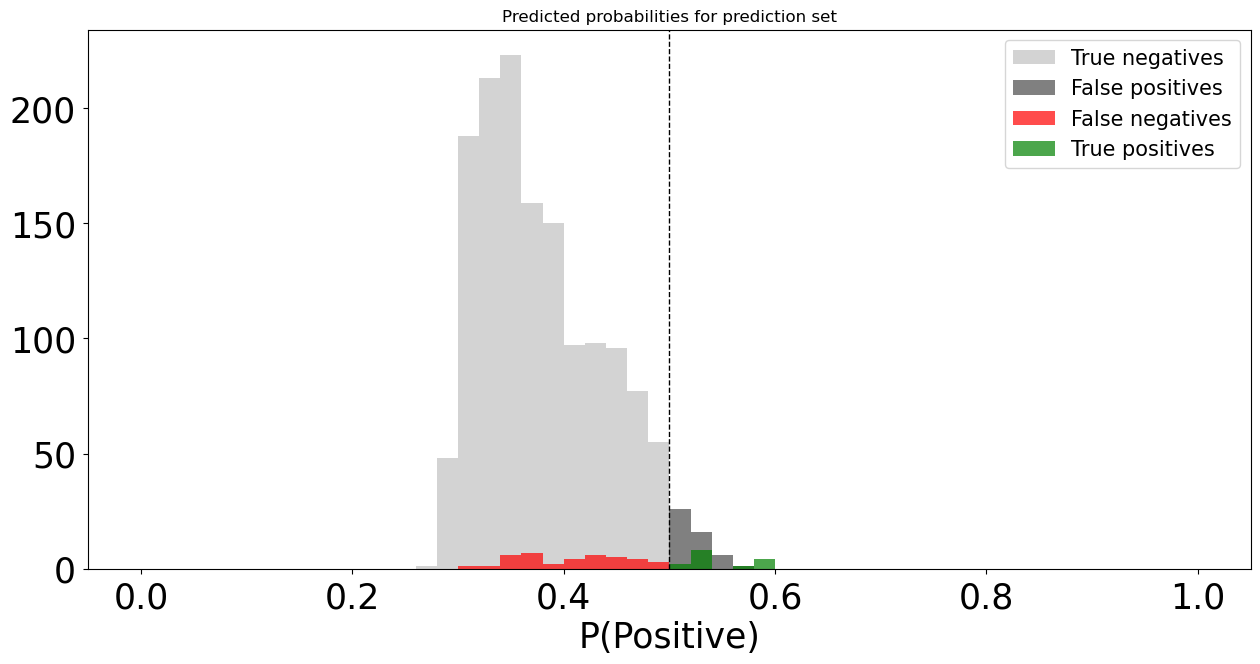

Test P(1) =  3.58%
Test P(1 | predicted 1) =  23.44%
Test P(1 | predicted 0) =  2.70%

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1454
           1       0.23      0.28      0.25        54

    accuracy                           0.94      1508
   macro avg       0.60      0.62      0.61      1508
weighted avg       0.95      0.94      0.94      1508



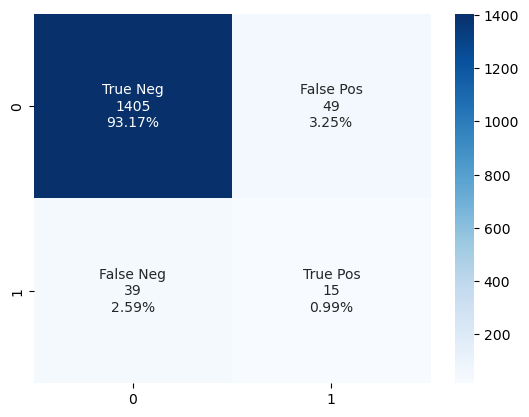

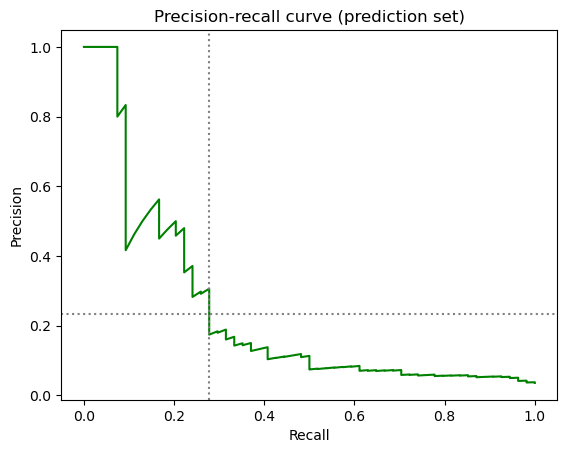

Predictions made: 1508
CPU times: user 1min 56s, sys: 1.4 s, total: 1min 58s
Wall time: 41min 35s


In [13]:
%%time

model_description = "Random forest"
model_scoring = 'f1'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=None, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None, 'balanced'], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=None, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_rf.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: XGBoost
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.25605512759424137
Parameters: {'subsample': 0.75, 'scale_pos_weight': 24.40449438202247, 'min_child_weight': 2, 'max_depth': 2}

Running prediction model...

  Training set: (4522, 699) (178 positive)
Prediction set: (1508, 699)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  100.00%
         Train precision:  100.00%
     Train avg precision:  100.00%
               Train F-1:  1.0
     Prediction accuracy:  96.29%
    Prediction precision:  45.00%
Prediction avg precision:  19.60%
          Prediction F-1:  0.24
      Test ROC_AUC Score:  0.58

Cross validation results: 

fit_time: 3.6731081008911133 (SD: 0.18060183012414002)
score_time: 0.005251598358154297 (SD: 0.00045002957988018224)
test_accuracy: 0.958205479228801 (

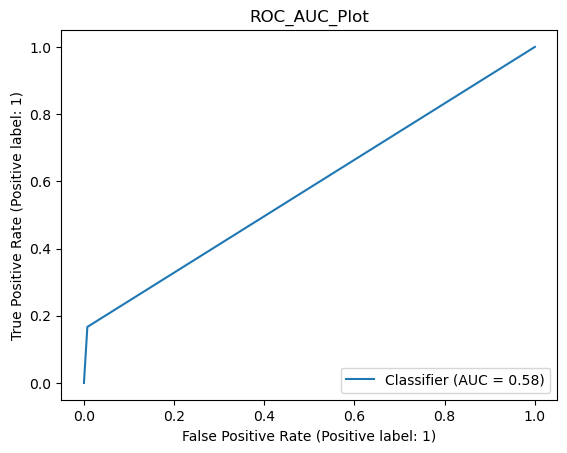

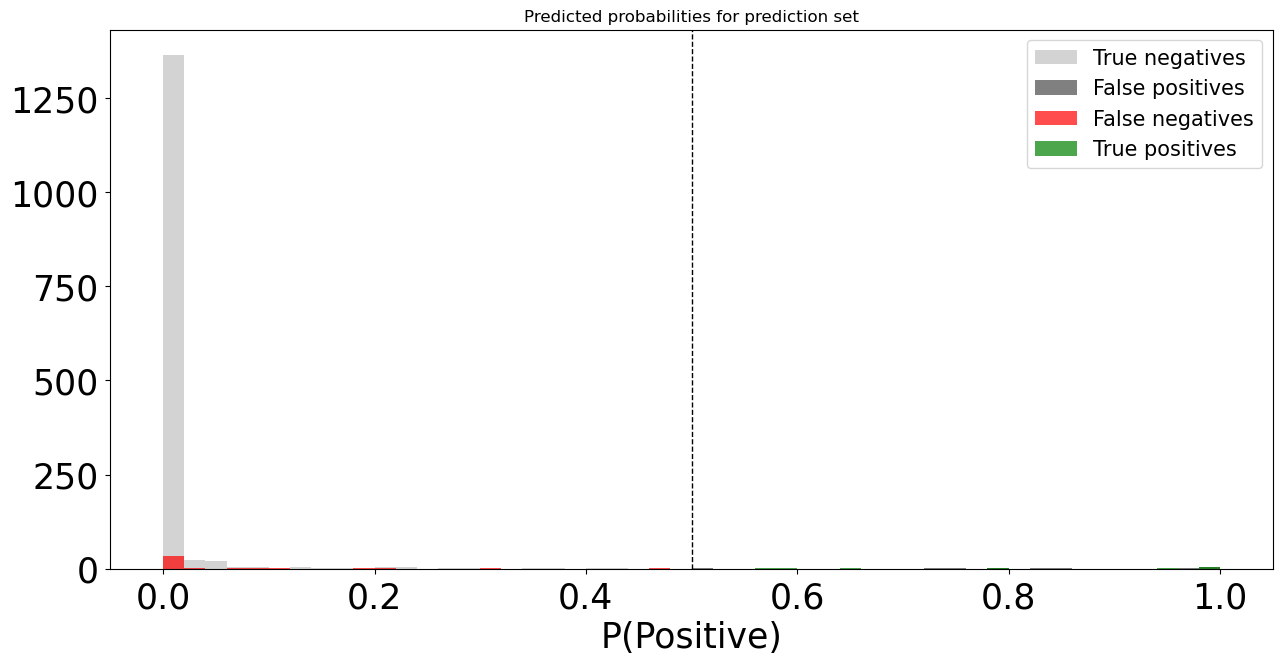

Test P(1) =  3.58%
Test P(1 | predicted 1) =  45.00%
Test P(1 | predicted 0) =  3.02%

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1454
           1       0.45      0.17      0.24        54

    accuracy                           0.96      1508
   macro avg       0.71      0.58      0.61      1508
weighted avg       0.95      0.96      0.95      1508



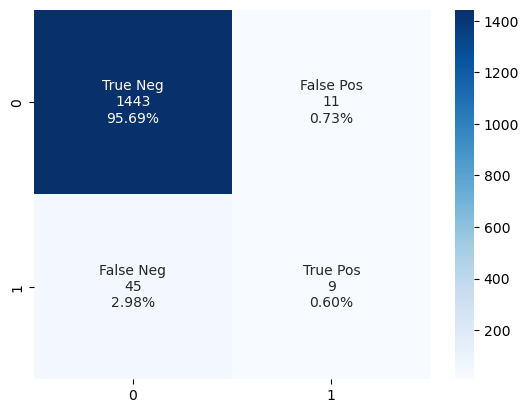

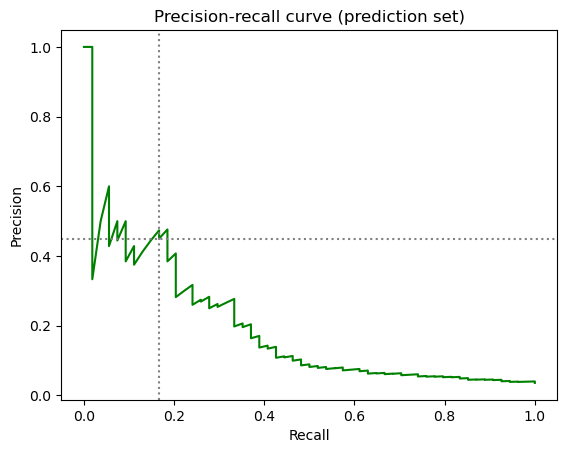

Predictions made: 1508
CPU times: user 7min 51s, sys: 8.81 s, total: 8min
Wall time: 21min 53s


In [14]:
%%time

model_description = "XGBoost"
model_scoring = 'f1'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1, surveyml.neg_train/surveyml.pos_train]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_xb.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Neural network
     Scoring: f1

Running prediction model...

  Training set: (4522, 699) (178 positive)
Prediction set: (1508, 699)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  92.44%
         Train precision:  32.70%
     Train avg precision:  68.58%
               Train F-1:  0.48
     Prediction accuracy:  88.53%
    Prediction precision:  15.20%
Prediction avg precision:  17.47%
          Prediction F-1:  0.23
      Test ROC_AUC Score:  0.69

Cross validation results: 

fit_time: 4.292052062352498 (SD: 0.1647890672877435)
score_time: 0.10011239051818847 (SD: 0.047878608709394976)
test_accuracy: 0.9066023729200281 (SD: 0.020066141464458356)
test_precision: 0.21268204884125191 (SD: 0.05428954753410785)
test_average_precision: 0.2670240550404681 (SD: 0.05768321538257274)
test_f1: 0.28889737653046993 (SD: 0.05639974879655535)
test_roc_auc: 0.7928587460284071 (SD: 0.05235507194514921)


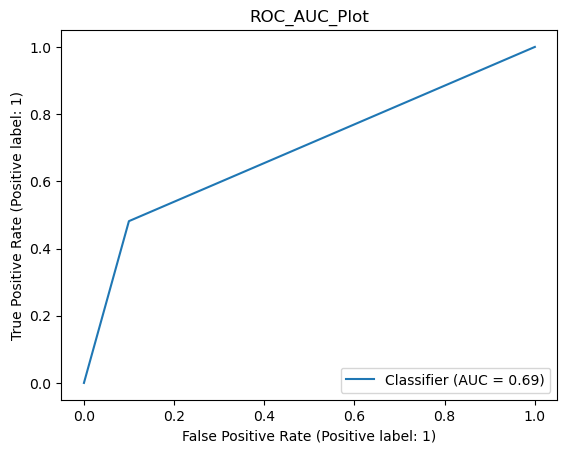

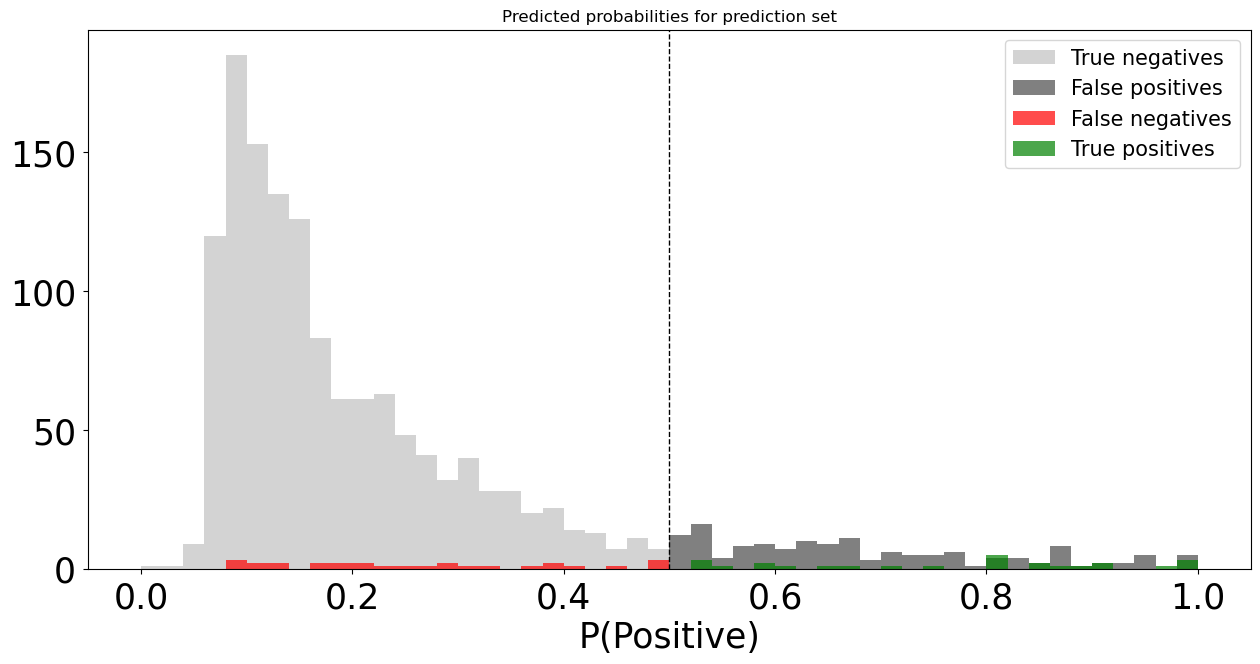

Test P(1) =  3.58%
Test P(1 | predicted 1) =  15.20%
Test P(1 | predicted 0) =  2.09%

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1454
           1       0.15      0.48      0.23        54

    accuracy                           0.89      1508
   macro avg       0.57      0.69      0.58      1508
weighted avg       0.95      0.89      0.91      1508



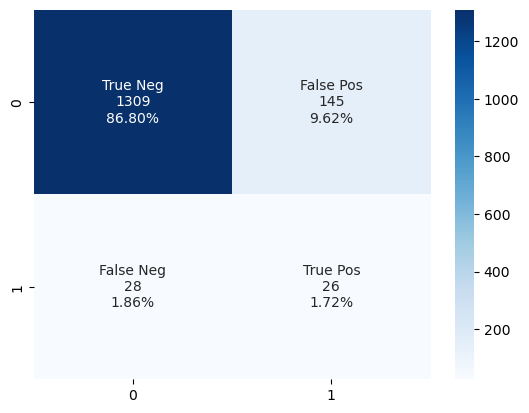

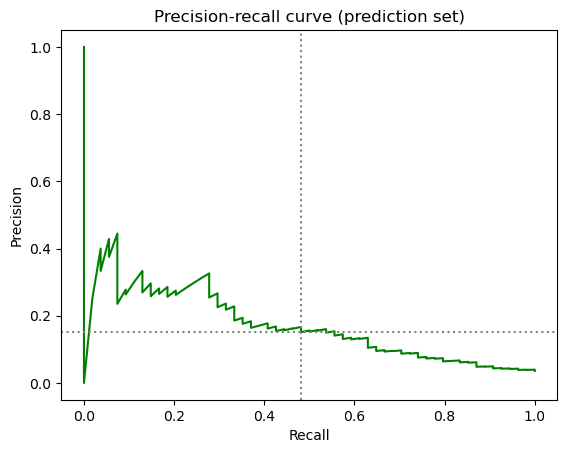

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_192 (Dropout)       (None, 699)               0         
                                                                 
 dense_192 (Dense)           (None, 349)               244300    
                                                                 
 dropout_193 (Dropout)       (None, 349)               0         
                                                                 
 dense_193 (Dense)           (None, 174)               60900     
                                                                 
 dropout_194 (Dropout)       (None, 174)               0         
                                                                 
 dense_194 (Dense)           (None, 1)                 175       
                                                                 
Total params: 305,375
Trainable params: 305,375
Non-t

In [15]:
%%time

model_description = "Neural network"
model_scoring = 'f1'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import numpy as np
from scikeras.wrappers import KerasClassifier

# # first use cross validation to find the optimal hyperparameters
# import sklearn as skl
# classifier_nn = KerasClassifier(model=surveyml.build_nn_model, verbose=0)
# #   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
# search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None, surveyml.class_weights], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
# params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# use results from earlier CV search
# Best f1: 0.2702094334907072
# Parameters: {'batch_size': 32, 'class_weight': {0: 0.5209677419354839, 1: 12.423076923076923}, 'epochs': 20, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__features': 699, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': 349.5, 'model__l2_factor': 0.030478144389072856, 'model__l2_regularization': True, 'model__output_bias': array([-3.17162294])}
params = {'epochs': 20, 'batch_size': 32, 'class_weight': surveyml.class_weights, 'model__features': surveyml.num_features, 'model__hidden_layers': 2, 'model__initial_units': int(surveyml.num_features / 2), 'model__activation': 'relu', 'model__l2_regularization': [True, False], 'model__l2_factor': 0.030478144389072856, 'model__include_dropout': True, 'model__dropout_rate': 0.5, 'model__output_bias': np.log([surveyml.pos_train/surveyml.neg_train])}

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print(classifier_nn.model_.summary())
print()
print(f"Predictions made: {len(predictions)}")